# Neuro4ML - Week 1 - Neurons



In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

# For Google Colab
if not os.path.exists('spikes.csv'):
  !git clone https://github.com/neuro4ml/exercises.git
  !cp exercises/w1-neurons/*.csv .

Cloning into 'exercises'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 124 (delta 17), reused 22 (delta 8), pack-reused 90 (from 1)
Receiving objects: 100% (124/124), 10.55 MiB | 17.04 MiB/s, done.
Resolving deltas: 100% (61/61), done.


## Part 1 - Coding a leaky integrate-and-fire neuron

Write code to simulate a leaky integrate-and-fire neuron with the following equation:

$$
\tau \frac{\mathrm{d}V}{\mathrm{d}t} = I(t)-v
$$

Here $I(t)$ is a time-varying input current to the neuron. Whenever $v>1$, the neuron emits a spike and instantly resets to $v=0$.

In the simulation, you should discrete time with steps of width $\mathrm{d}t$. That is, you want to find the values at $t=0, \mathrm{d}t, 2\mathrm{d}t, 3\mathrm{d}t, \ldots$.

Your code should assume $I(t)$ is provided as a numpy array of values so that ``I[k]`` corresponds to $I(k\cdot\mathrm{d}t)$. You should assume that time is measured in milliseconds, and your code should take the time constant $\tau$ as a parameter, as well as a simulation time step $\mathrm{d}t$. Your code should return an array ``V_rec`` of recorded values of $V$ at each time step, and an array ``spikes`` of the times of the spikes.

### Implementation steps

The simulation loop should look something like this.

Variables:

* ``V`` a float value that stores the membrane potential, initialised to value 0
* ``V_rec`` an array that will store the recorded membrane potential values, with length the number of time steps to be simulated
* ``spikes`` a list that will store the recorded spike times, initially empty
* ``I`` an array of input current values of length the number of time steps to be simulated
* ``tau`` the time constant
* ``dt`` the simulation time step
* Optionally, make ``threshold = 1``, ``reset = 0`` modifiable parameters

The algorithm should repeat the following for the number of time steps to be simulated:

1. Record the value of $V$ at the start of the loop.
2. Update the value of $V$ to reflect the value it should have at the next time step. That is, at the start of the loop it should have value $V(t)$ and at the end of the loop value $V(t+\mathrm{d}t)$. To do this, solve the differential equation to compute the value $V(t+\mathrm{d}t)$ in terms of $V(t)$, $\tau$, and $I(t)$. You can assume $I(t)$ to be constant in the interval $[t, t+\mathrm{d}t]$. If you want a hint to help solve the equation, scroll down to the bottom of this notebook.
3. Check the condition that $V>1$.
4. If this condition is satisfied, record a spike and reset $V=0$.

You can use this as a template:

In [6]:
# Function that runs the simulation
# I: input current
# tau: time constant (in ms)
# threshold: threshold value to produce a spike
# reset: reset value after a spike
# dt: simulation time step in ms
def LIF(I, tau=10, threshold=1.0, reset=0.0, dt=0.1):
    num_steps = len(I)
    V_rec = np.zeros(num_steps)
    spikes = [] # list to store spike times
    # FILL IN THE GAPS HERE
    V = 0.0
    # exact update for one step of width dt:
    # V(t+dt) = V(t)*exp(-dt/tau) + I(t)*(1 - exp(-dt/tau))
    alpha = np.exp(-dt / tau)

    for k in range(num_steps):
        # record V at the *start* of the step
        V_rec[k] = V

        # update to the end of the step using the closed-form solution
        V = V * alpha + I[k] * (1.0 - alpha)

        # threshold check; if spiked, record time and reset
        if V > threshold:
            spikes.append((k + 1) * dt)   # spike time at end of the step
            V = reset

    return V_rec, np.array(spikes)


### Testing your implementation

Write code to plot the output of your simulation, and verify that with the following values you get results similar to the figure below for a simulation duration of 100 ms.

* $\tau = 10$ ms
* $I(t) = 3\sin^2(2\pi f t)$ for $f=10$ Hz

Assuming your function is called ``LIF`` you can use the following code to test your implementation:

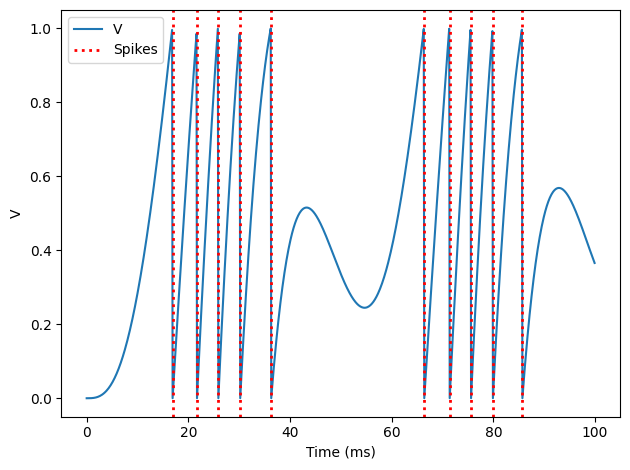

In [7]:
dt = 0.1
T = np.arange(1000)*dt*1e-3
V_rec, spikes = LIF(3*np.sin(2*np.pi*10*T)**2, tau=10, dt=dt)
plt.plot(np.arange(len(V_rec))*dt, V_rec, label='V')
for i, t in enumerate(spikes):
    plt.axvline(t, ls=':', c='r', lw=2, label='Spikes' if i==0 else None)
plt.xlabel('Time (ms)')
plt.ylabel('V')
plt.legend(loc='best')
plt.tight_layout()

## Part 2 - Fitting a LIF neuron to data

In this exercise, you will try to fit your LIF neuron to some real data. Actually, the "real data" is just generated from a more complex model, but it's the same idea.

First of all, we load the data and plot it. The data is the input current that was injected into the neuron ``state_I`` which is a numpy array of shape ``(repeats, num_time_steps)`` and is measured in nA (nanoamps). The experiment was repeated 10 times with 10 different random currents ``state_I[0, :]``, ``state_I[1, :]``, etc. In response, the membrane potentials ``state_V`` with the same shape were recorded (measured in mV, millivolts). Finally, you have the array of spike times ``(spike_t, spike_i)`` which are 1d arrays of length the total number of spikes recorded. ``spike_t[i]`` is the time of spike ``i`` (in ms) and ``spike_i[i]`` is the index of which repeat it was (from 0 to 9).

In the code below, we plot this data normalised so we can see all the data on one plot.

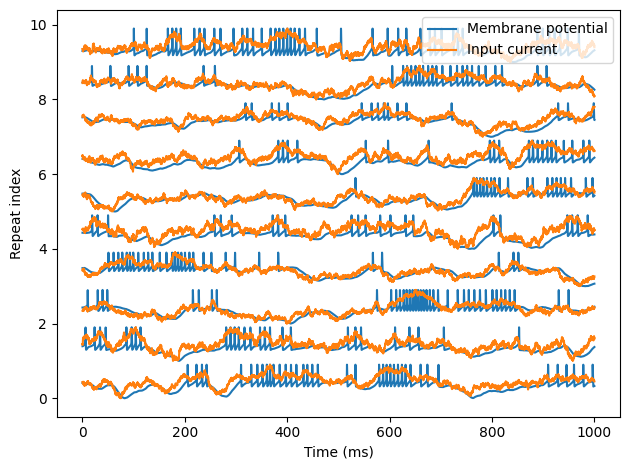

In [ ]:
state_I = np.loadtxt('current.csv') # shape (repeats, num_time_steps)
state_v = np.loadtxt('traces.csv') # shape (repeats, num_time_steps)
spike_t, spike_i = np.loadtxt('spikes.csv') # shape (num_spikes,)
repeats, num_time_steps = state_I.shape
state_t = np.arange(num_time_steps)*0.1 # in ms

# Plot the data to get a look at it
def normalise(x):
    return (x-x.min())/(x.max()-x.min())
for idx_repeat in range(repeats):
    plt.plot(state_t, idx_repeat+0.9*normalise(state_v[idx_repeat, :]), c='C0', label='Membrane potential' if idx_repeat==0 else None)
    plt.plot(state_t, idx_repeat+0.9*normalise(state_I[idx_repeat, :]), c='C1', label='Input current' if idx_repeat==0 else None)
plt.xlabel('Time (ms)')
plt.ylabel('Repeat index')
plt.legend(loc='best')
plt.tight_layout()

Now we want to find the parameters of a simple, leaky integrate and fire neuron that best fits this data. In this scenario, we don't care about fitting the membrane potentials necessarily, we just want to fit the spike times. We use the van Rossum metric to compute the distance between two sets of spike times. If you're interested, you can read more about this [here](http://www.scholarpedia.org/article/Measures_of_spike_train_synchrony#van_Rossum_distance), although for the sake of this exercise you can just use the code below.

The function ``van_rossum_distance(t0, t1, duration)`` returns the distance between two spikes trains ``t0`` and ``t1`` (arrays of times, can be different lengths) over a given ``duration`` (all measured in ms).

The function ``mean_vr_distance(data_spikes, model_spikes, duration)`` gives the mean value of this for the set of 10 repeats. The format of ``data_spikes`` and ``model_spikes`` is a list of arrays, where item ``i`` in the list gives the spike times of repeat ``i``. The value of ``data_spikes`` is computed for you, so you only need to generate ``model_spikes``.

In [ ]:
def van_rossum_distance(t0, t1, duration, tau=5, dt=0.1):
    n = int(np.round(duration/dt))
    x0 = np.zeros(n)
    x1 = np.zeros(n)
    for x, t in [(x0, t0), (x1, t1)]:
        x[np.array(np.round(t/dt), dtype=int)] = 1
    nk = int(np.round(3*tau/dt))
    if 2*nk+1>n:
        nk = (n-1)//2
    T = np.arange(-nk, nk+1)*dt
    kernel = np.exp(-T/tau)/tau
    for x in [x0, x1]:
        x[:] = np.convolve(x, kernel, 'same')
    return np.sqrt(np.sum((x0-x1)**2*dt)/tau)

def mean_vr_distance(data_spikes, model_spikes, duration, tau=5, dt=0.1):
    d = 0
    for t0, t1 in zip(data_spikes, model_spikes):
        d += van_rossum_distance(t0, t1, duration, tau=tau, dt=dt)
    d /= len(data_spikes)
    return d

# Convert (t, i) format to list
data_spikes = []
for idx_repeat in range(repeats):
    data_spikes.append(spike_t[spike_i==idx_repeat])

The code below is one example of using the ``LIF`` function above. In addition to the ``tau`` parameter we've added two extra parameters ``a`` and ``b`` which give a linear transformation of the input current ``a*I+b``, which could help to give a better fit. As you can see, with these parameters the fit is not great.

15.146979473572566

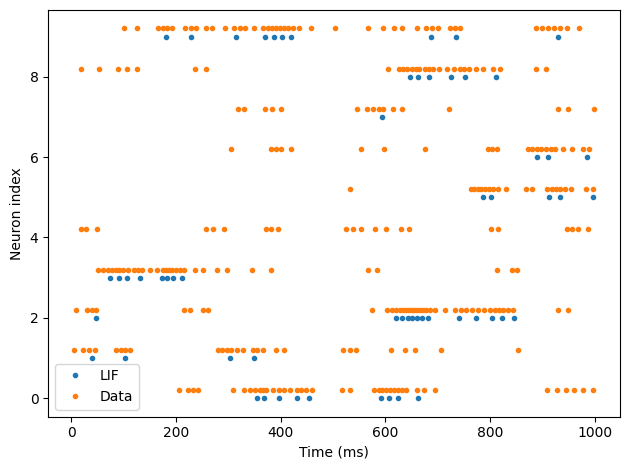

In [ ]:
def eval_LIF(I, sp_t, sp_i, a, b, tau_ms, do_plot=False):
    repeats, num_time_steps = I.shape
    model_spikes = []
    for idx_repeat in range(repeats):
        _, spikes = LIF(a*I[idx_repeat, :]+b, tau=tau_ms)
        model_spikes.append(spikes)
        if do_plot:
            plt.plot(spikes, idx_repeat*np.ones(len(spikes)), '.', c='C0', label='LIF' if idx_repeat==0 else None)
    if do_plot:
        plt.plot(sp_t, sp_i+0.2, '.', c='C1', label='Data')
        plt.legend(loc='best')
        plt.xlabel('Time (ms)')
        plt.ylabel('Neuron index')
        plt.tight_layout()
    return mean_vr_distance(data_spikes, model_spikes, num_time_steps*0.1)

eval_LIF(state_I, spike_t, spike_i, a=3, b=0, tau_ms=50, do_plot=True)


Now over to you. You're free to do this however you like, and at the end of the class we'll have a competition to see which group managed to fit it best (lowest mean van Rossum distance between model and data). One option is just to try to make this fit better by hand. Another is to try using an optimisation library (e.g. you could try using the CMA-ES package which is easy to install in Python with just ``!pip install cma``). Or you could take it further and try adapting the LIF model, e.g. by adding adaptation or using a different neuron model.

Good luck and have fun!

## Hint for differential equation

You want to solve $\tau v^\prime=I-v$. Start by making the substitution $u=v-I$ where you assume $I$ is constant. This should give you a standard / recognisable differential equation for $u$. Solve this in general to get an expression with a constant. Use the fact that you know the value of $v(t)$ to find the value of the constant, and substitute this back in to find the value at time $t+\mathrm{d}t$.